Transaction Data Columns: Index(['transaction_id', 'customer_id', 'transaction_date',
       'transaction_amount', 'transaction_type', 'transaction_amount_scaled',
       'transaction_amount_normalized'],
      dtype='object')
Product Data Columns: Index(['product_id', 'product_name', 'product_type', 'risk_level',
       'target_age_group', 'target_income_group'],
      dtype='object')


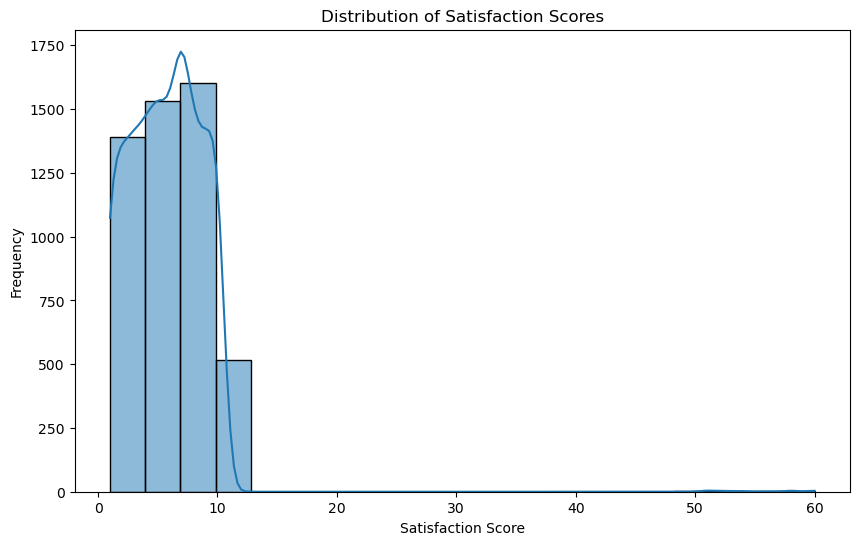

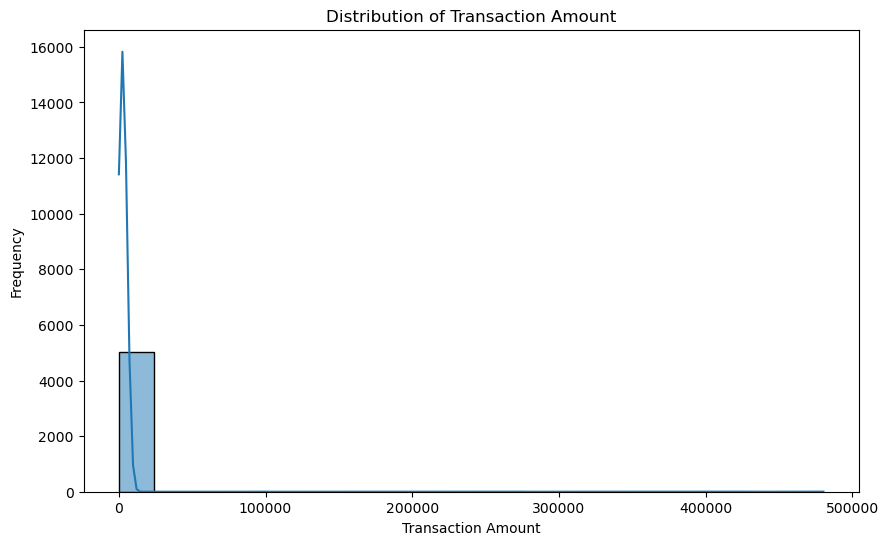

Error: 'product_type' column not found in merged transaction data


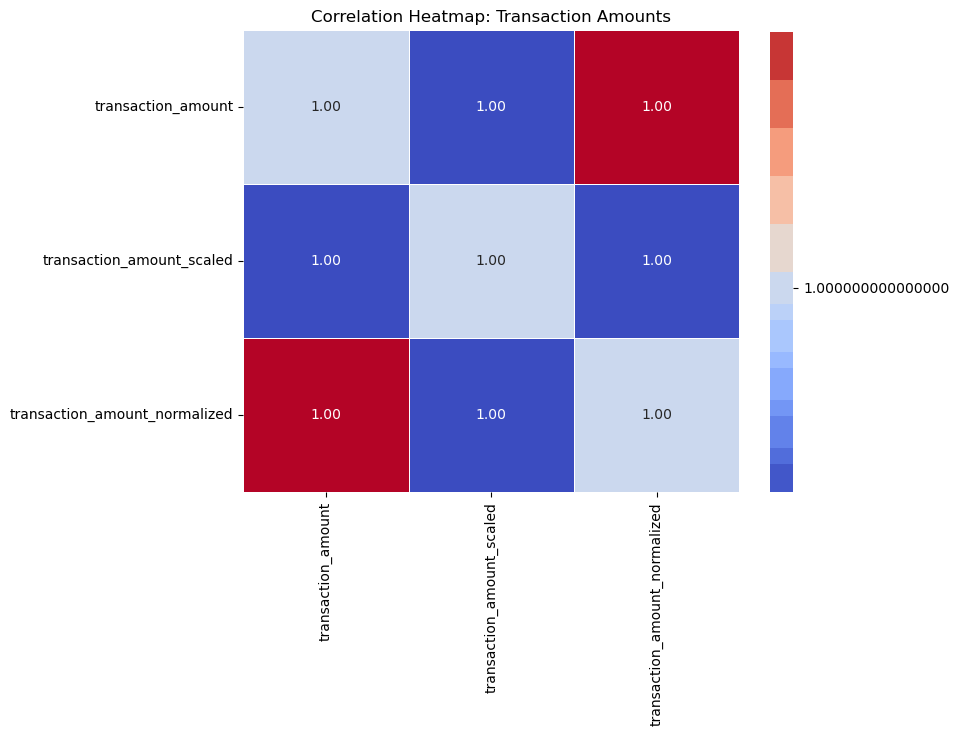

   transaction_id  customer_id     transaction_date  transaction_amount  \
0               1          393  2023-01-01 00:00:00         3472.000000   
1               2          826  2023-01-01 01:00:00         3094.726465   
2               3          916  2023-01-01 02:00:00           10.000000   
3               4          109  2023-01-01 03:00:00           72.000000   
4               5          889  2023-01-01 04:00:00         1793.000000   

   transaction_amount_scaled  transaction_amount_normalized  \
0                   0.007208                       0.025718   
1                   0.006423                       0.000000   
2                   0.000000                      -0.210281   
3                   0.000129                      -0.206054   
4                   0.003712                      -0.088737   

   transaction_type_Investment  transaction_type_Loan Payment  \
0                        False                          False   
1                        False          

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load Data
customer = pd.read_csv(r"C:\Users\User\Downloads\Customer_Feedback_Data.csv")
product = pd.read_csv(r"C:\Users\User\Downloads\Product_Offering_Data.csv")
transaction = pd.read_csv(r"C:\Users\User\Downloads\Transaction_Data.csv")

# 1. Clean Data: Strip whitespace from column names
customer.columns = customer.columns.str.strip().str.lower().str.replace(' ', '_')
product.columns = product.columns.str.strip().str.lower().str.replace(' ', '_')
transaction.columns = transaction.columns.str.strip().str.lower().str.replace(' ', '_')

# 2. Handle Missing Data
# Customer Data: Handle Missing Satisfaction Scores
customer['satisfaction_score'] = customer['satisfaction_score'].fillna(customer['satisfaction_score'].mode()[0])

# Transaction Data: Handle Missing Transaction Amounts
transaction['transaction_amount'] = transaction['transaction_amount'].fillna(transaction['transaction_amount'].mean())

# Product Data: Handle Missing Target Age Group
product['target_age_group'] = product['target_age_group'].fillna('Unknown')

# 3. Feature Engineering: Add Transaction Amount Normalization
scaler = MinMaxScaler()
transaction['transaction_amount_scaled'] = scaler.fit_transform(transaction[['transaction_amount']])

scaler = StandardScaler()
transaction['transaction_amount_normalized'] = scaler.fit_transform(transaction[['transaction_amount']])

# 4. Check if 'product_id' Exists in both DataFrames Before Merging
if 'product_id' in transaction.columns and 'product_id' in product.columns:
    print("Both 'product_id' columns are found, proceeding with merge...")
    
    # 5. Merge Transaction Data with Product Data based on Product_ID
    transaction = transaction.merge(product[['product_id', 'product_type']], on='product_id', how='left')
    
    # Handle missing 'product_type' values by filling them with 'Unknown'
    transaction['product_type'] = transaction['product_type'].fillna('Unknown')
else:
    print("Warning: 'product_id' column not found in transaction or product data")
    print("Transaction Data Columns:", transaction.columns)
    print("Product Data Columns:", product.columns)

# 6. Handle One-Hot Encoding for Transaction Type (Optional)
transaction = pd.get_dummies(transaction, columns=['transaction_type'], drop_first=True)

# 7. Exploratory Data Analysis (EDA)
# Distribution of Satisfaction Score
plt.figure(figsize=(10, 6))
sns.histplot(customer['satisfaction_score'], kde=True, bins=20)
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.show()

# Distribution of Transaction Amount
plt.figure(figsize=(10, 6))
sns.histplot(transaction['transaction_amount'], kde=True, bins=20)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# Boxplot: Transaction Amount by Product Type
if 'product_type' in transaction.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='product_type', y='transaction_amount', data=transaction)
    plt.title('Transaction Amount by Product Type')
    plt.xlabel('Product Type')
    plt.ylabel('Transaction Amount')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Error: 'product_type' column not found in merged transaction data")

# Correlation Heatmap: Transaction Amount, Transaction Amount Scaled, and Satisfaction Score
corr = transaction[['transaction_amount', 'transaction_amount_scaled', 'transaction_amount_normalized']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Transaction Amounts')
plt.show()

# 8. Save Cleaned Data
customer.to_csv('cleaned_customer_feedback.csv', index=False)
transaction.to_csv('cleaned_transaction_data.csv', index=False)
product.to_csv('cleaned_product_offering_data.csv', index=False)

# Show Head of Transaction Data to Verify Changes
print(transaction.head())
